# Nguyen Trung Tuyen - Kiem tra giua ki 04/06/2024

In [400]:
(2152260823 % 3) + 1

2

# Đề 2: Phân tích Arima , Garch

## Đọc dữ liệu

In [401]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model

In [402]:
file_path = './data-kiem-tra-2.csv'
data = pd.read_csv(file_path, sep=',', encoding='ISO-8859-1')
data.dropna()
data

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,10.05.2013,4,58,3773,299.0,1
1,26.05.2013,4,58,3768,249.0,1
2,19.05.2013,4,58,4036,419.0,1
3,25.05.2013,4,58,12878,149.0,1
4,15.05.2013,4,58,12885,148.0,1
...,...,...,...,...,...,...
550033,07.11.2013,10,37,18474,199.0,1
550034,18.11.2013,10,37,18474,199.0,1
550035,24.11.2013,10,37,18484,199.0,1
550036,11.11.2013,10,37,19751,99.0,1


### Kiểm tra các ngày trùng lặp

In [403]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

duplicate_dates = data[data.duplicated(['date'], keep=False)]

duplicate_dates_count = duplicate_dates['date'].nunique()
duplicate_dates_list = duplicate_dates['date'].unique()

duplicate_dates_count, duplicate_dates_list

(214,
 <DatetimeArray>
 ['2013-05-10 00:00:00', '2013-05-26 00:00:00', '2013-05-19 00:00:00',
  '2013-05-25 00:00:00', '2013-05-15 00:00:00', '2013-05-30 00:00:00',
  '2013-05-18 00:00:00', '2013-05-11 00:00:00', '2013-05-01 00:00:00',
  '2013-05-31 00:00:00',
  ...
  '2013-11-25 00:00:00', '2013-11-13 00:00:00', '2013-11-21 00:00:00',
  '2013-11-08 00:00:00', '2013-11-05 00:00:00', '2013-11-12 00:00:00',
  '2013-11-28 00:00:00', '2013-11-26 00:00:00', '2013-11-19 00:00:00',
  '2013-11-27 00:00:00']
 Length: 214, dtype: datetime64[ns])

### Thực hiện nhóm các ngày bị trùng và tính giá trị tổng của các ngày đó

In [404]:

data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

data_grouped = data.groupby('date').sum().reset_index()

data_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      214 non-null    datetime64[ns]
 1   truong_1  214 non-null    int64         
 2   truong_2  214 non-null    int64         
 3   truong_3  214 non-null    int64         
 4   truong_4  214 non-null    float64       
 5   truong_5  214 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 10.2 KB


In [405]:
feats = ['truong_1', 'truong_2', 'truong_3','truong_4', 'truong_5']
data = data_grouped[feats]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   truong_1  214 non-null    int64  
 1   truong_2  214 non-null    int64  
 2   truong_3  214 non-null    int64  
 3   truong_4  214 non-null    float64
 4   truong_5  214 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 8.5 KB


## EDA

### Biểu đồ phân phối của các cột trong data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   truong_1  214 non-null    int64  
 1   truong_2  214 non-null    int64  
 2   truong_3  214 non-null    int64  
 3   truong_4  214 non-null    float64
 4   truong_5  214 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 8.5 KB
None
           truong_1       truong_2      truong_3      truong_4     truong_5
count    214.000000     214.000000  2.140000e+02  2.140000e+02   214.000000
mean   17745.303738   84836.780374  2.653458e+07  1.754358e+06  3251.042056
std     9616.699485   42747.652566  1.272667e+07  8.341662e+05  1640.250174
min     2652.000000   11370.000000  4.254984e+06  2.875204e+05   478.000000
25%    10017.500000   36628.000000  1.268014e+07  8.402174e+05  1548.500000
50%    18841.000000   93107.500000  2.882267e+07  1.867573e+06  3419.500000
75%    22871.500000  111646.250000  

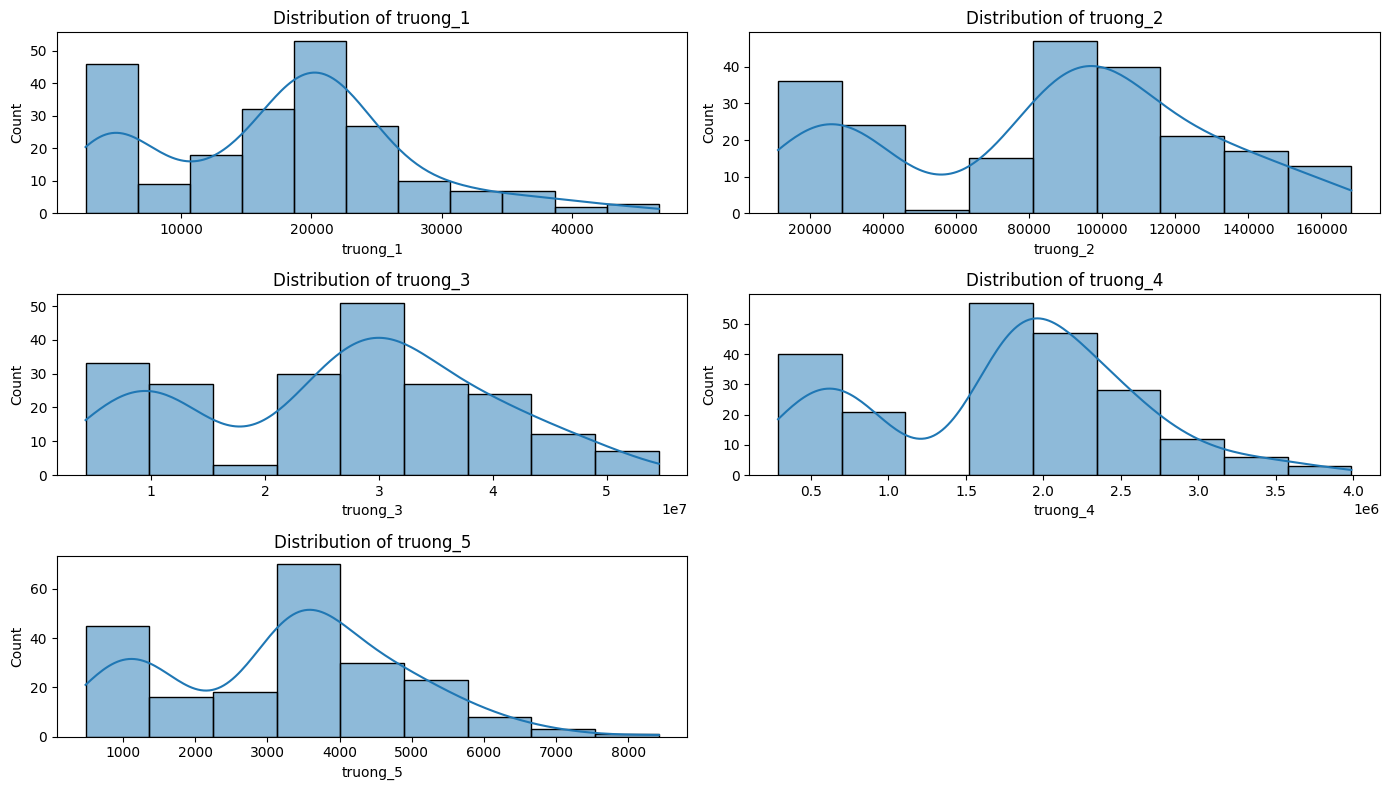

In [406]:
import matplotlib.pyplot as plt
import seaborn as sns

print(data.info())
print(data.describe())

plt.figure(figsize=(14, 8))

for i, column in enumerate(data.columns):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data[column], kde=True)
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

### Biểu đồ tương quan giữa các cột với nhau

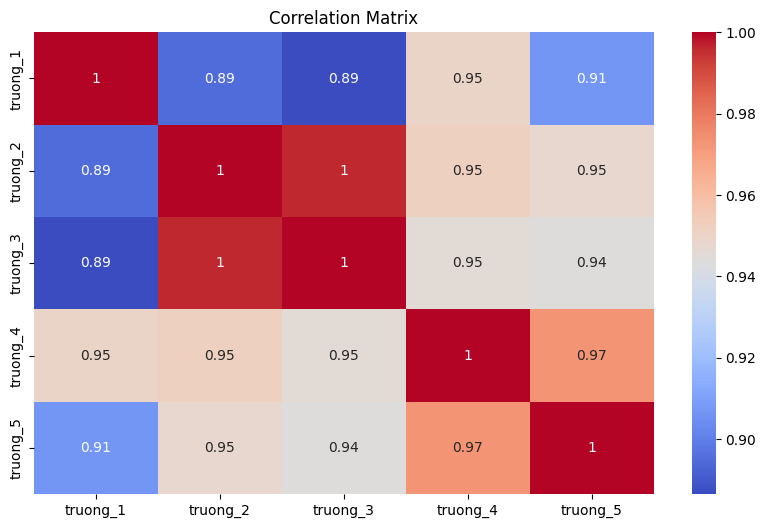

In [407]:
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Chọn cột để sử dụng

Dựa vào ma trận tương quan đã vẽ được ở trên:

- Truong_4 có mối tương quan rất cao với truong_5 (0.97) và cũng có mối tương quan mạnh với truong_1 (0.95), truong_2 (0.95), và truong_3 (0.95). Điều này cho thấy truong_4 chứa nhiều thông tin có tính chất tương quan với các trường khác.

- Truong_4 thể hiện sự ổn định và đồng nhất trong mối tương quan với tất cả các trường khác (đều có tương quan trên 0.95), điều này có thể chỉ ra rằng truong_4 có thể là đại diện tốt cho dữ liệu tổng thể.

- Sử dụng truong_4 có thể giúp tránh dư thừa thông tin, do truong_4 đã có mức độ tương quan cao với các cột khác, điều này có nghĩa là nó đã bao quát được phần lớn thông tin cần thiết.

Từ đó mà sẽ chọn cột 4 để thực hiện dự đoán cũng như tính toán ở các mô hình bởi vì:

- Truong_4 nó chứa nhiều thông tin tổng hợp từ các trường khác và có tính đồng nhất cao, giúp giảm thiểu dư thừa thông tin trong mô hình phân tích.

In [408]:
feats = ['truong_4']
data = data[feats]
data

,truong_4
0,8.699411e+05
1,8.025867e+05
2,8.121575e+05
3,6.420660e+05
4,5.800663e+05
...,...
209,3.712670e+05
210,3.011002e+05
211,3.666039e+05
212,8.222827e+05


## Mô hình Arima

### Kiểm tra tính dừng của dữ liệu

In [409]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9073541872065587
p-value: 0.32860941740377164


Do giá trị pvalue > 0.05 nên dữ liệu chưa dừng, cần thực hiện sai phân trước khi đưa vào mô hình

### Sai phân để chuyển dữ liệu sang chuỗi dừng

In [410]:
data_diff = data.diff().dropna()

result = adfuller(data_diff)
print('ADF Statistic (differenced):', result[0])
print('p-value (differenced):', result[1])


ADF Statistic (differenced): -3.753019482490075
p-value (differenced): 0.003426268398189828


Sau khi thực hiện tính sai phân bậc 1 thì dữ liệu đã trở thành chuỗi dừng
=> tham số d được chọn ở đây là bằng 1

### Vẽ biểu đồ ACF và PACF

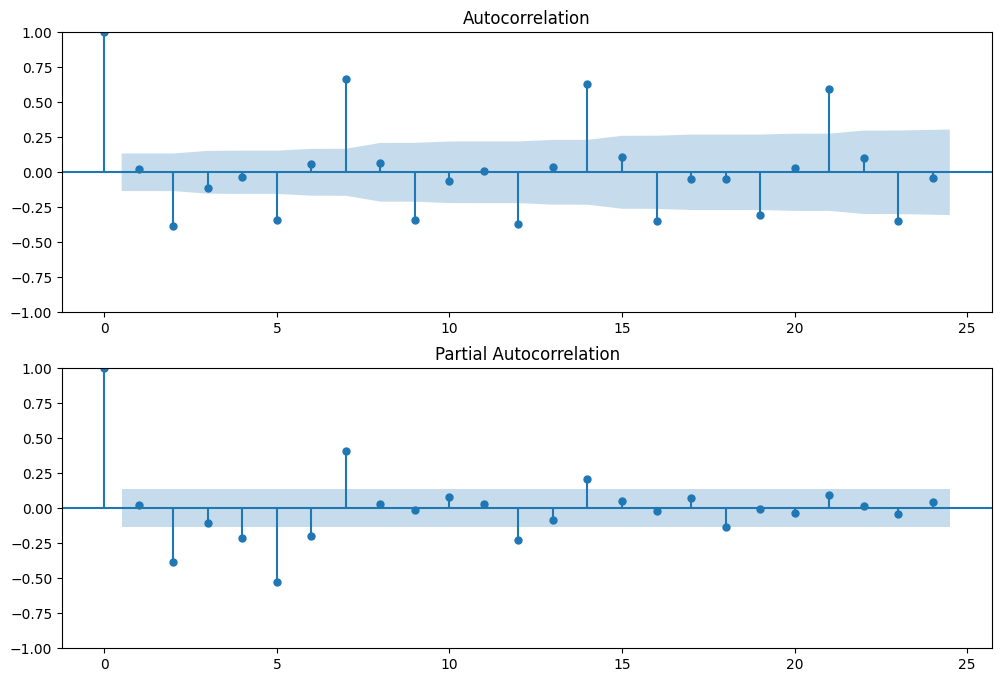

In [411]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data_diff, ax=ax[0])
plot_pacf(data_diff, ax=ax[1])

plt.show()

Nhìn vào biểu đồ ACF ta có thể xác định được tham số q của mô hình:

- Có 11 giá trị lag vượt qua khỏi ngưỡng tin cậy => Chọn q = 11

Nhìn vào biểu dồ PACF, ta có thể xác định được tham số p của mô hình:

- Có 7 giá trị lag vượt qua khỏi ngưỡng tin cậy = > chọn p = 7

### Xây dựng mô hình 

In [412]:
train_data = data_diff.iloc[:-15]  
test_data = data_diff.iloc[-15:]

In [413]:

p = 7
d = 1
q = 11

model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               truong_4   No. Observations:                  198
Model:                ARIMA(7, 1, 11)   Log Likelihood               -2771.559
Date:                Tue, 04 Jun 2024   AIC                           5581.119
Time:                        12:07:23   BIC                           5643.500
Sample:                             0   HQIC                          5606.371
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1958     32.750     -0.037      0.971     -65.384      62.992
ar.L2         -1.1916     32.291     -0.037      0.971     -64.481      62.098
ar.L3         -1.1798     32.260     -0.037      0.9

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Dự báo 15 ngày trong tập test

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


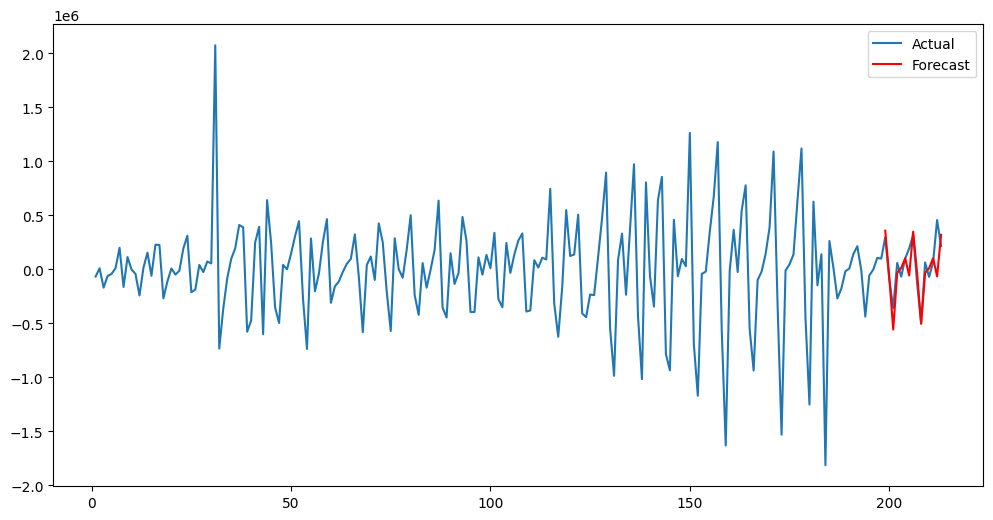

            Actual       Forecast
199  296594.027525  356976.722374
200  -92404.002525  -65696.683216
201 -358085.622619 -558009.529807
202   58676.780952  -33998.909555
203  -67978.000000   13234.406621
204   99422.479039  101951.015253
205  192848.594626  -56944.523788
206  318758.096969  348036.340067
207 -131405.630952  -38315.098979
208 -500871.873016 -503982.620910
209   63412.000000  -33310.630490
210  -70166.833333   10008.747336
211   65503.733333  102639.675668
212  455678.788963  -65918.366106
213  214915.311030  319117.880172


In [414]:
forecast = model_fit.forecast(steps=15)
forecast.index = test_data.index

plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Actual')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

forecast_df = pd.DataFrame({'Actual': test_data['truong_4'], 'Forecast': forecast})
print(forecast_df)

### Tính toán độ chính xác và độ lỗi của mô hình

In [415]:
r2 = r2_score(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mse)

print(f"R-squared: {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

R-squared: 0.5188565120332582
Mean Squared Error (MSE): 28768875314.22732
Mean Absolute Error (MAE): 111902.4715847797
Root Mean Squared Error (RMSE): 169613.90071048812


## Mô hình Garch

In [416]:
data

,truong_4
0,8.699411e+05
1,8.025867e+05
2,8.121575e+05
3,6.420660e+05
4,5.800663e+05
...,...
209,3.712670e+05
210,3.011002e+05
211,3.666039e+05
212,8.222827e+05


Việc chọn tham số ở mô hình này cũng tương tự như mô hình Arima mà ta đã thực hiện ở trên. Như đã chọn ở trên ta chọn:

- Giá trị của p = 7

- Giá trị của q = 11

### Huấn luyện mô hình Garch 

In [417]:
train_data = data_diff.iloc[:-30]  
test_data = data_diff.iloc[-30:] 

model = arch_model(train_data, vol='Garch', p=7, q=11)
model_fit = model.fit()

print(model_fit.summary())

Iteration:      1,   Func. Count:     22,   Neg. LLF: 2614.9078723773832
Iteration:      2,   Func. Count:     43,   Neg. LLF: 2618.802224001039
Iteration:      3,   Func. Count:     66,   Neg. LLF: 2684.8777841931424
Iteration:      4,   Func. Count:     90,   Neg. LLF: 2730.5678260042073
Iteration:      5,   Func. Count:    112,   Neg. LLF: 2613.6387281772
Iteration:      6,   Func. Count:    134,   Neg. LLF: 2617.8013079539323
Iteration:      7,   Func. Count:    157,   Neg. LLF: 2615.24649530831
Iteration:      8,   Func. Count:    179,   Neg. LLF: 2612.4053570755023
Iteration:      9,   Func. Count:    200,   Neg. LLF: 2612.4029670313776
Iteration:     10,   Func. Count:    221,   Neg. LLF: 2612.402886509819
Iteration:     11,   Func. Count:    242,   Neg. LLF: 2612.402886031656
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2612.402886031656
            Iterations: 11
            Function evaluations: 242
            Gradient evaluations

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.314e+11. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


### Dự báo tập test

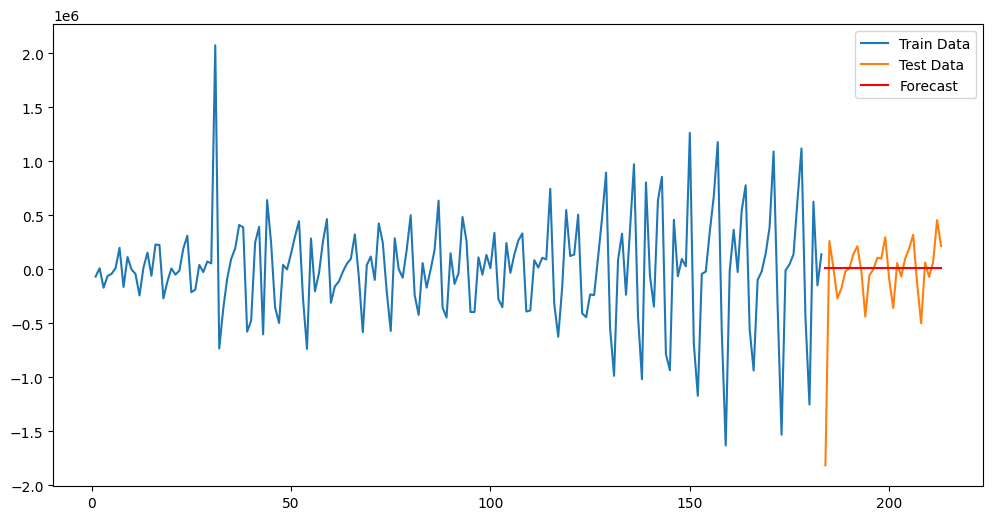

In [418]:
forecast = model_fit.forecast(horizon=30)

forecast_mean = forecast.mean.iloc[-1, :30].values

forecast_mean_df = pd.Series(forecast_mean, index=test_data.index)

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data')
plt.plot(forecast_mean_df, label='Forecast', color='red')
plt.legend()
plt.show()
forecast_df = pd.DataFrame({'Actual': test_data['truong_4'], 'Forecast': forecast_mean_df})


In [419]:

r2 = r2_score(test_data, forecast_mean_df)
mse = mean_squared_error(test_data, forecast_mean_df)
mae = mean_absolute_error(test_data, forecast_mean_df)
rmse = np.sqrt(mse)

print(f"R-squared Garch: {r2}")
print(f"Mean Squared Error (MSE) Garch: {mse}")
print(f"Mean Absolute Error (MAE) Garch: {mae}")
print(f"Root Mean Squared Error (RMSE) Garch: {rmse}")

R-squared Garch: -0.019963241053313263
Mean Squared Error (MSE) Garch: 156304888621.9334
Mean Absolute Error (MAE) Garch: 220142.5364030313
Root Mean Squared Error (RMSE) Garch: 395354.13064989395
